# Theory

[Anonymous Walk Embeddings](https://arxiv.org/abs/1805.11921)

[Helpful Explanation Video](https://www.youtube.com/watch?v=VVml3nDiM3E)

## Introduction

**Random Walks**  
Random walks are the sequences of nodes, where each new node is selected independently from the set of neighbors of the last node in the sequence. 

Let $s = (u_1, u_2, . . . , u_k)$ be an ordered
list of elements $u_i \in \mathcal V$ ($u_i$ is a Vertex from the Graph). We define the positional function pos: $(s, u_i) → q$ such that for any ordered list $s = (u_1, u_2, . . . , u_k)$ and an element $u_i \in \mathcal V$ it returns a list $q = (p_1, p_2, . . . , p_l)$ of all positions $p_j \in \mathcal N$ of $u_i$ occurrences in a list $s$.

**For example**

If $s = (a, b, c, b, c)$ , then $pos(s, a) = (1)$ as element a appears only on the first position and $pos(s, b) =
(2, 4)$ as element b appears on the second and forth position.



**Anonymous Walks**

If $w = (v_1, v_2, . . . , v_k)$ is a random walk, then its corresponding anonymous walk is the sequence of integers $a = (f(v_1)$ , $f(v_2), . . . , f(v_k))$ , where integer $f(v_i) = min pos(w, v_i)$.
We denote mapping of $a$ random walk $w$ to anonymous walk $a$ by $w → a$.



![Random Walk to Anonymous Walk](image1.png)

Let $A_l =(a_1^u, a_2^u, . . . , a_η^u)$ be the set of all possible anonymous walks of length $l$ ($η$ is the number of all possible anonymous walks of length $l$). Anonymous walk embedding of a graph $G$ is the vector $f_G$ of size $η$, whose i-th component corresponds to a probability $p(a_i)$, of having anonymous walk $a_i$ in a graph $G$:
$$f_G = (p(a_1), p(a_2), . . . , p(a_η)).$$

The probability of having a random walk in a Graph is the product of the weight of the edges.
Where $w$ is a random walk.

![Probability of choosing a Random Walk](image5.png)

The Probability of seeing an Anonymous Walk from the set: $A_l^u =(a_1, a_2, . . . , a_η)$.

![Probability of choosing a Random Walk](image4.png)

Where $p(a_i)$ is :

![Probability of choosing a Anonymous Walk](image3.png)

Where $u$ is a Vertex in Graph $G$, $w_e$ is the weight of an Edge, $p(w)$ is a probability of having a random walk $w$ which is equal to the product of all the weights of that walk. $W_u^l$ are all the different random walks that start from $u$ and have length $l$.

![Number of Anonymous Walks of a certain Length](image2.png)

**MUTAG DATASET**

In particular, MUTAG is a collection of nitroaromatic compounds and the goal is to predict their mutagenicity on Salmonella typhimurium. Input graphs are used to represent chemical compounds, where vertices stand for atoms and are labeled by the atom type (represented by one-hot encoding), while edges between vertices represent bonds between the corresponding atoms. It includes 188 samples of chemical compounds with 7 discrete node labels.

## Code

In [165]:
from __future__ import division

import networkx as nx
import random, time, math, os, sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import argparse
import re
from collections import Counter
import linecache
import random

## Random Walker

In [166]:
class RandomWalker:
    """
    Class to do fast first-order random walks.
    Args:
        walk_length (int): Number of random walks.
        walk_number (int): Number of nodes in truncated walk.
    """

    def __init__(self, walk_length: int, walk_number: int, G = None):
        self.graph = G
        self.walk_length = walk_length
        self.walk_number = walk_number

    def do_walk(self, node):
        """
        Doing a single random walk from a source node.
            node - The source node of the random walk.
            walk(list of strings) - A single random walk.
        """
        walk = [node]
        for _ in range(self.walk_length):
            nneighbors = [node for node in self.graph.neighbors(walk[-1])]
            if len(nneighbors) > 0:
                walk = walk + random.sample(nneighbors, 1)
        walk = [str(w) for w in walk]
        return walk
    
    def do_walks(self, graph):
        """
        Doing a fixed number of random walks from every node in the graph.
            graph(NetworkX graph) - The graph to run the random walks on.
        """
        self.walks = []
        self.graph = graph
        for node in graph.nodes():
            for _ in range(self.walk_number):
                walk_from_node = self.do_walk(node)   #('n0') #(0)
                self.walks.append(walk_from_node)
        return self.walks


## Anonymous Walk

In [186]:
class AnonymousWalks(object):
    '''
    Computes Anonymous Walks of a Graph.
    Class has a method to embed a graph into a vector space using anonymous walk distribution.
    '''
    def __init__(self, G = None):
        self._graph = G
        self.paths = dict()
        self.__methods = ['exact']

    @property
    def graph(self):
        return self._graph

    @graph.setter
    def graph(self, G):
        self._graph = G

    def read_graph_from_text(self, filename, header = True, weights = True, sep = ',', directed = False):
        '''Read from Text Files.'''
        G = nx.Graph()
        if directed:
            G = nx.DiGraph()
        with open(filename) as f:
            if header:
                next(f)
            for line in f:
                splitted = line.strip().split(sep) #reads the nodes
                u = splitted[0]
                v = splitted[1]
                G.add_edge(u, v) #add a edge between the 2 nodes
                if weights: #add the weights
                    w = float(splitted[2])
                    G[u][v]['weight'] = w
        self.graph = G
        return self.graph

    def read_graphml(self, filename):
        '''Read graph from graphml format.'''
        self.graph = nx.read_graphml(filename)
        return self.graph

    def create_random_walk_graph(self):
        '''Creates a probabilistic graph from graph.
        If edges have parameter "weight" then it will use the weights in computing probabilities.'''
        if self.graph is None:
            raise ValueError("You should first create a weighted graph.")

        label_name = 'weight'

        RW = nx.DiGraph()
        for node in self.graph:
            edges = self.graph[node]
            total = float(sum([edges[v].get(label_name, 1) for v in edges if v != node]))
            for v in edges:
                if v != node:
                    RW.add_edge(node, v, weight = edges[v].get(label_name,1) / total)
        self.rw_graph = RW

    def _all_paths(self, steps, keep_last = False):
        '''Get all possible anonymous walks of length up to steps.'''
        paths = []
        last_step_paths = [[0, 1]]
        for i in range(2, steps+1):
            current_step_paths = []
            for j in range(i + 1):
                for walks in last_step_paths:
                    if walks[-1] != j and j <= max(walks) + 1:
                        paths.append(walks + [j])
                        current_step_paths.append(walks + [j])
            last_step_paths = current_step_paths
        if keep_last:
            paths = list(filter(lambda path: len(path) ==  steps + 1, paths))
        self.paths[steps] = paths

    def walk2pattern(self, walk):
        '''Converts a walk with arbitrary nodes to anonymous walks, without considering labels.'''
        idx = 0
        pattern = []
        d = dict()
        for node in walk:
            if node not in d:
                d[node] = idx #the node gets the index idx
                idx += 1
            pattern.append(d[node])
        return tuple(pattern)

    def _random_walk_node(self, node, steps):
        '''Creates anonymous walk from a node for arbitrary steps.
        Returns a tuple with consequent nodes.'''
        d = dict()
        d[node] = 0
        count = 1
        walk = [d[node]]
        for i in range(steps):
            v = self._random_step_node(node)
            if v not in d:
                d[v] = count
                count += 1
            walk.append(d[v])
            node = v
        return tuple(walk)
    
    def _random_step_node(self, node):
        '''Moves one step from the current node to a random neighbor node.
        Return next node.'''
        if self.rw_graph is None:
            raise ValueError("Create a Random Walk graph first with {}".format(self.create_random_walk_graph.__name__))
        walk = [node]
        nneighbors = [node2 for node2 in self.rw_graph.neighbors(walk[-1])]
        if len(nneighbors) > 0:
            walk = walk + random.sample(nneighbors, 1)
        walk = [str(w) for w in walk]
        return int(walk[-1])

    def _anonymous_walk(self, node, steps, labels = None):
        '''Creates anonymous walk for a node.'''
        if labels is None:
            return self._random_walk_node(node, steps)

    def _exact(self, steps, labels = None, prop = True, verbose = True):
        '''Find anonymous walk distribution exactly.
        Returns dictionary pattern to probability.'''
        walks = dict() #all walks that happend and the probability of them happening
        all_walks = [] #all possible unique walks to the specified length

        def patterns(RW, node, steps, walks, current_walk=None, current_dist=1.):
            # RW is a graph of random walks
            if current_walk is None:
                current_walk = [node]  #adding the node to curren walk
            if len(current_walk) > 1: 
                all_walks.append(current_walk) #adding current walk to all walks
                if labels is None:
                    w2p = self.walk2pattern(current_walk) #transforms a walk to a anonymous walk if labels in None
                else:
                    raise ValueError('labels argument should be None.')
                amount = current_dist #current  dist in 1 at the beginning
                if prop:
                    amount /= len(RW) #if prop is true, we normalize amount
                walks[w2p] = walks.get(w2p, 0) + amount  #if w2p does not exist pe put 0 and add amount
            if steps > 0:
                for v in RW[node]:
                    patterns(RW, v, steps - 1, walks, current_walk + [v], current_dist * RW[node][v]['weight'])
                    #we apply the function recursive

        for node in self.rw_graph:
            patterns(self.rw_graph, node, steps, walks) #we apply patterns for every node
        if verbose:
            print('Total walks of size {} in a graph:'.format(steps), len(all_walks))
        return walks
    
    def embed(self, steps, method = 'exact', prop=True, labels = None, keep_last = False, verbose = True):
        '''Get embeddings of a graph using anonymous walk distribution.
        Return vector and meta information as dictionary.'''

        # Create a random walk instance of the graph first
        self.create_random_walk_graph()

        if labels is None:
            self._all_paths(steps, keep_last) #Get all possible anonymous walks of length = steps
        else:
            raise ValueError('labels argument should be None.')

        if method == 'exact':
            if verbose:
                print("Use exact method to get vector representation.")
            start = time.time()
            patterns = self._exact(steps, labels = labels, prop=prop, verbose=verbose)
            finish = time.time()
            if verbose:
                print('Spent {} sec to get vector representation via exact method.'.format(round(finish - start, 2)))
        else:
            raise ValueError("Wrong method for AnonymousWalks.")


        vector = []
        if verbose:
            print(patterns)
        for path in self.paths[steps]:
            vector.append(patterns.get(tuple(path), 0))
        return vector, {'meta-paths': self.paths[steps]}

        

In [187]:
class GraphKernel(object):
    ''' Reading graphs from the files. '''
    def __init__(self, graphs = None):
        self.gv = AnonymousWalks()
        self.graphs = graphs
        self.__methods = ['linear', 'rbf', 'poly']
        
    def read_graphs(self, filenames = None, folder = None, ext = None, header=True, weights=True, sep=',', directed=False):
        '''Read graph from the list of files or from the folder.
        If filenames is not None, then read graphs from the list in filenames.
        Then, if folder is not None, then read files from the folder. 
        If extension is specified, then read only files with this extension.
        If folder is not None, then filenames should be named as follows graph0.graphml 
        and should follow the same order as in labels.txt'''
        
        if filenames is None and folder is None:
            raise ValueError("You should provide list of filenames or folder with graphs")
        if filenames is not None:
            self.graphs = []
            for filename in filenames:
                if filename.split('.')[-1] == 'graphml':
                    G = self.gv.read_graphml(folder + '/' + filename)
                else:
                    G = self.gv.read_graph_from_text(folder + '/' + filename, header, weights, sep, directed)
                self.graphs.append(G)
        elif folder is not None:
            self.graphs = []
            # have the same order of graphs as in labels.txt
            folder_graphs = filter(lambda g: g.endswith(max(ext, '')), os.listdir(folder))
            sorted_graphs = sorted(folder_graphs, key=lambda g: int(re.findall(r'\d+', g)[0]))
            for item in sorted_graphs:
                if ext is not None:
                    if item.split('.')[-1] == ext:
                        if ext == 'graphml':
                            G = self.gv.read_graphml(folder + '/' + item)
                        else:
                            G = self.gv.read_graph_from_text(folder + '/' + item, header, weights, sep, directed)
                        self.graphs.append(G)
                else:
                    if item.split('.')[-1] == 'graphml':
                        G = self.gv.read_graphml(folder + '/' + item)
                    else:
                        G = self.gv.read_graph_from_text(folder + '/' + item, header, weights, sep, directed)
                    self.graphs.append(G)

In [188]:
gk = GraphKernel()
gk.read_graphs(folder = 'Datasets/mutag', ext = 'graphml')

print('Number of graphs: {}'.format(len(gk.graphs)))
print()
print(gk.graphs[100])

Number of graphs: 188

Graph with 23 nodes and 27 edges


### The Graph we use

In [189]:
G = gk.graphs[100]

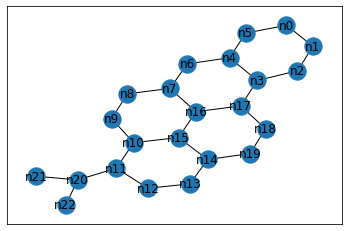

In [190]:
nx.draw_networkx(G, pos = nx.kamada_kawai_layout(G))

### One random walk of lenght 4 starting from node "n0"

In [191]:
b = RandomWalker(4,2,G)
b.do_walk('n0')

['n0', 'n5', 'n0', 'n1', 'n0']

### Two random walks of lenght 4 starting from each node

In [192]:
b.do_walks(G)

[['n0', 'n5', 'n4', 'n5', 'n4'],
 ['n0', 'n1', 'n2', 'n3', 'n17'],
 ['n1', 'n0', 'n5', 'n4', 'n3'],
 ['n1', 'n2', 'n1', 'n2', 'n3'],
 ['n2', 'n3', 'n2', 'n1', 'n0'],
 ['n2', 'n3', 'n17', 'n16', 'n17'],
 ['n3', 'n17', 'n3', 'n4', 'n5'],
 ['n3', 'n4', 'n5', 'n0', 'n1'],
 ['n4', 'n5', 'n4', 'n6', 'n7'],
 ['n4', 'n6', 'n7', 'n16', 'n7'],
 ['n5', 'n4', 'n3', 'n4', 'n6'],
 ['n5', 'n4', 'n6', 'n7', 'n6'],
 ['n6', 'n7', 'n6', 'n4', 'n6'],
 ['n6', 'n4', 'n6', 'n7', 'n6'],
 ['n7', 'n6', 'n7', 'n16', 'n15'],
 ['n7', 'n16', 'n17', 'n3', 'n4'],
 ['n8', 'n9', 'n8', 'n9', 'n10'],
 ['n8', 'n7', 'n8', 'n9', 'n10'],
 ['n9', 'n8', 'n7', 'n16', 'n7'],
 ['n9', 'n8', 'n7', 'n6', 'n4'],
 ['n10', 'n11', 'n20', 'n21', 'n20'],
 ['n10', 'n15', 'n16', 'n17', 'n3'],
 ['n11', 'n10', 'n15', 'n10', 'n9'],
 ['n11', 'n10', 'n15', 'n14', 'n13'],
 ['n12', 'n13', 'n12', 'n13', 'n14'],
 ['n12', 'n11', 'n10', 'n9', 'n10'],
 ['n13', 'n14', 'n13', 'n14', 'n15'],
 ['n13', 'n12', 'n11', 'n20', 'n21'],
 ['n14', 'n19', 'n18', 'n1

### All possible anonymous walks of length 3

In [193]:
awe = AnonymousWalks(G)
length = 3 # length of anonymous walks

awe._all_paths(steps=length, keep_last = True)
print('All possible anonymous walks of length {} '.format(length))
print(awe.paths[length])

All possible anonymous walks of length 3 
[[0, 1, 2, 0], [0, 1, 0, 1], [0, 1, 2, 1], [0, 1, 0, 2], [0, 1, 2, 3]]


### The Random Walk graph

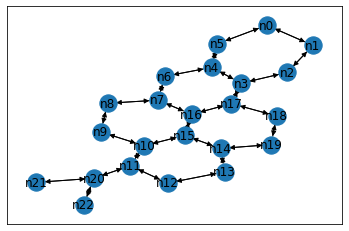

In [200]:
nx.draw_networkx(awe.rw_graph, pos = nx.kamada_kawai_layout(awe.rw_graph))

### The probability of an anonymous walk of length 3 being in the RW graph

In [195]:
length = 3
embedding, meta = awe.embed(steps = length, method = 'exact', keep_last=True, verbose=False)

aws = meta['meta-paths']
print('The probability of an anonymous walk being in the graph:')
print(embedding)
print()
print('Anonymous Walks of length {}:'.format(length))
print(aws)

The probability of an anonymous walk being in the graph:
[0, 0.1932367149758453, 0.2544283413848631, 0.22705314009661837, 0.3252818035426736]

Anonymous Walks of length 3:
[[0, 1, 2, 0], [0, 1, 0, 1], [0, 1, 2, 1], [0, 1, 0, 2], [0, 1, 2, 3]]


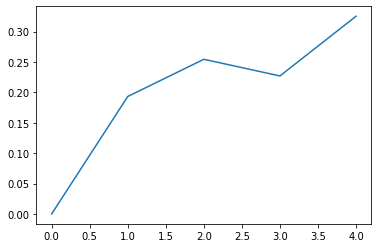

In [196]:
plt.plot(embedding)

### All possible anonymous walks of length 4

In [208]:
awe2 = AnonymousWalks(G)
length = 4 # length of anonymous walks

awe2._all_paths(steps=length, keep_last = True)
print('All possible anonymous walks of length {} '.format(length))
print(awe2.paths[length])

All possible anonymous walks of length 4 
[[0, 1, 0, 1, 0], [0, 1, 2, 1, 0], [0, 1, 0, 2, 0], [0, 1, 2, 3, 0], [0, 1, 2, 0, 1], [0, 1, 0, 2, 1], [0, 1, 2, 3, 1], [0, 1, 2, 0, 2], [0, 1, 0, 1, 2], [0, 1, 2, 1, 2], [0, 1, 2, 3, 2], [0, 1, 2, 0, 3], [0, 1, 2, 1, 3], [0, 1, 0, 2, 3], [0, 1, 2, 3, 4]]


### The Random Walk graph

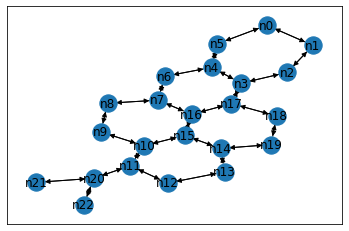

In [214]:
nx.draw_networkx(awe.rw_graph, pos = nx.kamada_kawai_layout(awe.rw_graph))

### The probability of an anonymous walk of length 4 being in the RW graph

In [182]:
length = 4
embedding, meta = awe2.embed(steps = length, method = 'exact', keep_last=True, verbose=False)

aws = meta['meta-paths']
print('The probability of an anonymous walk being in the graph:')
print(embedding)
print()
print('Anonymous Walks of length {}:'.format(length))
print(aws)

The probability of an anonymous walk being in the graph:
[0.08574879227053141, 0.09889962426194307, 0.09889962426194303, 0, 0, 0, 0, 0, 0.10748792270531404, 0.09889962426194307, 0.1369431025228128, 0, 0.0566290928609769, 0.12815351583467527, 0.18833870101986094]

Anonymous Walks of length 4:
[[0, 1, 0, 1, 0], [0, 1, 2, 1, 0], [0, 1, 0, 2, 0], [0, 1, 2, 3, 0], [0, 1, 2, 0, 1], [0, 1, 0, 2, 1], [0, 1, 2, 3, 1], [0, 1, 2, 0, 2], [0, 1, 0, 1, 2], [0, 1, 2, 1, 2], [0, 1, 2, 3, 2], [0, 1, 2, 0, 3], [0, 1, 2, 1, 3], [0, 1, 0, 2, 3], [0, 1, 2, 3, 4]]


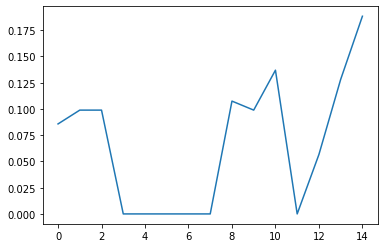

In [142]:
plt.plot(embedding)